In [1]:
import sys
import os
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from scipy.stats import gamma

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)

import polars as pl

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state=5, n_jobs=-1)

from classification_pipeline import cat_pipiline

from yellowbrick.classifier import ROCAUC

df = pl.read_parquet('../smalldata/classification.parquet')
df_prepared = cat_pipiline(df)
y_lst = ['cat__PlayType', 'cat__offenseFormation', 'cat__passResult', 'cat__passLocationType', 'cat__passTippedAtLine']



def y_select(columns_name):
    """Creates test and train data for the given target column"""
    X_ = df_prepared.drop(columns_name)
    y_ = df_prepared.select(columns_name).to_numpy().ravel()

    X_train, X_test, y_train, y_test = train_test_split(
        X_, y_, test_size=0.25, random_state=42, shuffle=True
        ,stratify=y_
    )

    return X_train, X_test, y_train, y_test

In [2]:
X_train, X_test, y_train, y_test=y_select('cat__PlayType')
X_test, X_val, y_test, y_val=train_test_split(X_test, y_test, test_size=0.25, random_state=42, stratify=y_test)


# Initial predictions

In [3]:
from sklearn.model_selection import cross_val_score

cross_val_score(lr, X_train, y_train, cv=3, scoring="accuracy")

/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

array([0.94132211, 0.94155523, 0.9576523 ])

/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


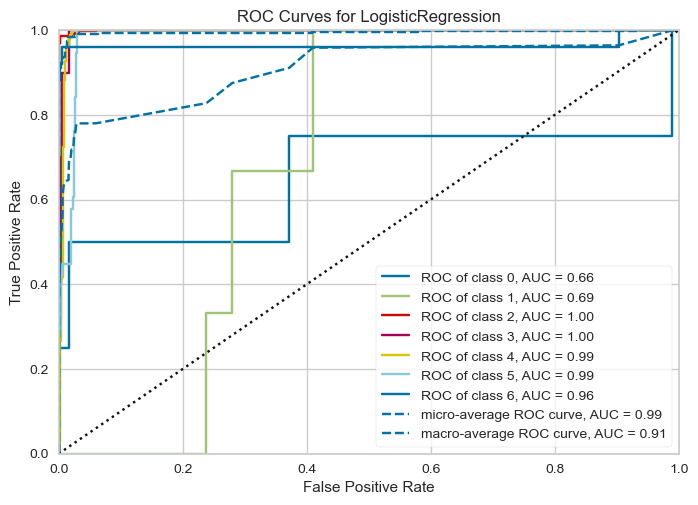

<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [5]:
visualizer=ROCAUC(lr, per_class=True)
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_val, y_val)        # Evaluate the model on the test data
visualizer.show()

/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


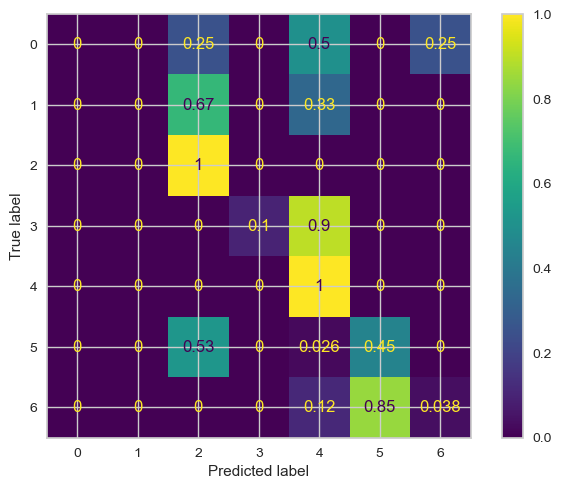

In [6]:

lr.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(lr, X_val, y_val, normalize='true')

# Fine-tuning

In [7]:
distributions=dict(
    penalty=['l1', 'l2', 'elasticnet', 'none'],
    C=gamma(a=1, scale=1),
    solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    l1_ratio=gamma(a=1, scale=1)
)
clf=RandomizedSearchCV(lr, distributions, random_state=0, n_iter=10, cv=5, n_jobs=-1)
search=clf.fit(X_train, y_train)

search.best_params_ 

/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning

{'C': 1.0446124955007756,
 'l1_ratio': 0.45924814117793333,
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [8]:
best_params={'C': 1.0446124955007756,
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [9]:
lr.set_params(**best_params)
#lr.fit(X_train, y_train)

LogisticRegression(C=1.0446124955007756, n_jobs=-1, random_state=5,
                   solver='newton-cg')

## Validation

In [10]:
cross_val_score(lr, X_train, y_train, cv=3, scoring="accuracy")

array([0.99529587, 0.99702823, 0.99702823])

In [11]:
cross_val_score(lr, X_val, y_val, cv=3, scoring="accuracy")

array([0.99109792, 0.99109792, 0.98809524])

/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


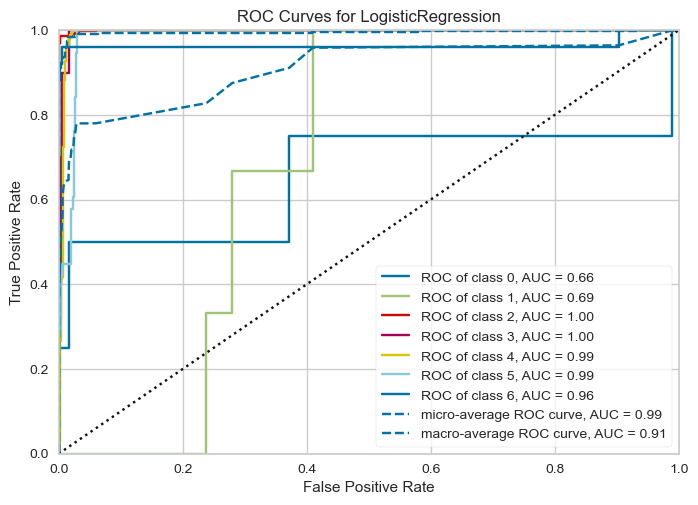

<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [12]:
visualizer=ROCAUC(lr, per_class=True)
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_val, y_val)        # Evaluate the model on the test data
visualizer.show()

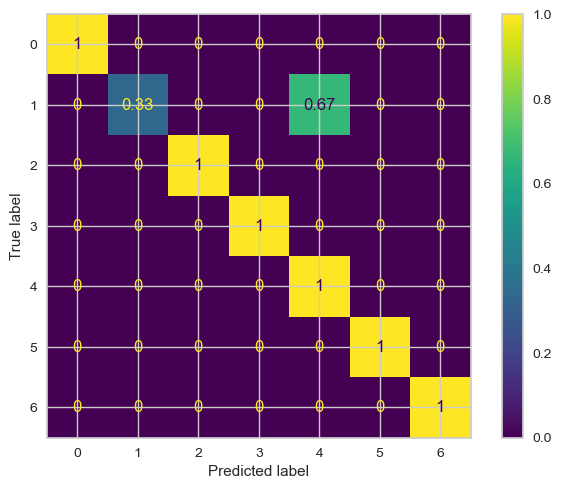

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
lr.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(lr, X_val, y_val, normalize='true')

## Further tuning for class 1

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
lr.set_params(class_weight="balanced")


LogisticRegression(C=1.0446124955007756, class_weight='balanced', n_jobs=-1,
                   random_state=5, solver='newton-cg')

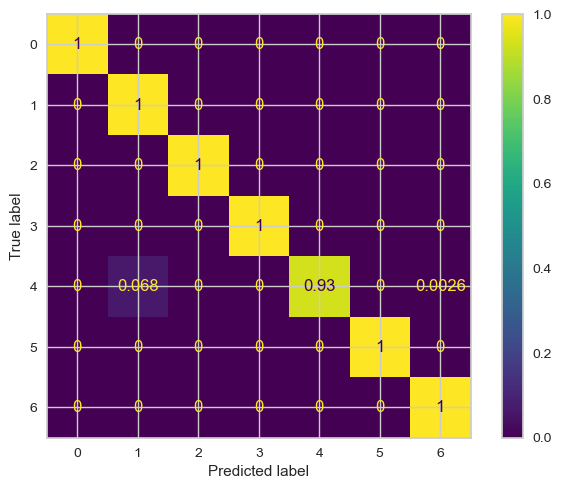

In [15]:
lr.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(lr, X_val, y_val, normalize='true')

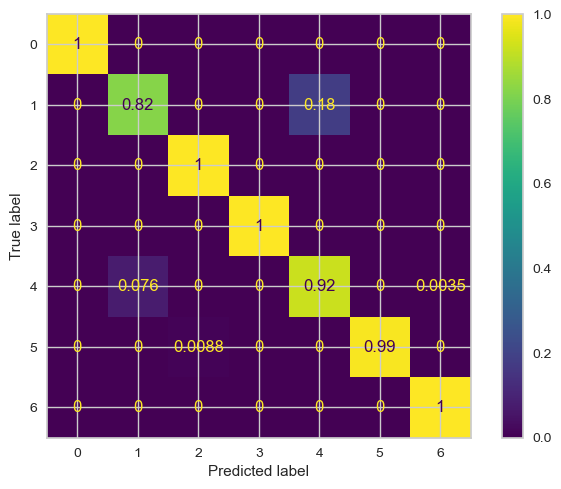

In [16]:
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test, normalize='true')

# Generating synthetic data

In [17]:
df = pl.read_parquet('../smalldata/classification.parquet')
df_prepared = cat_pipiline(df)
from sdv.metadata import Metadata

metadata = Metadata.detect_from_dataframe(
    data=df_prepared.to_pandas(),
    table_name='BDB')


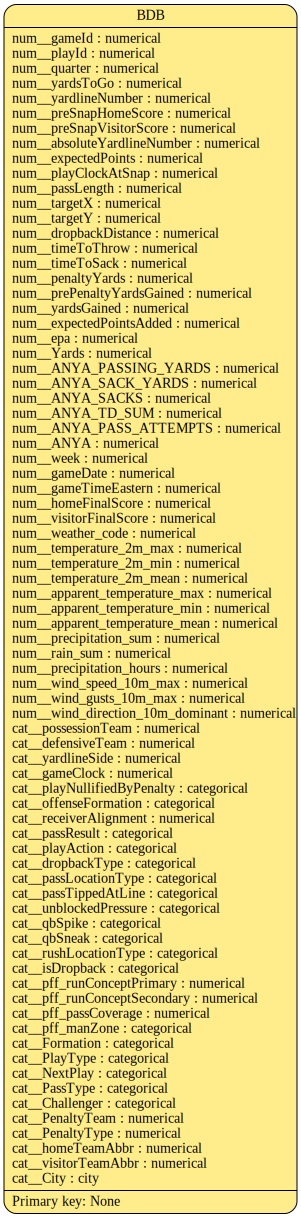

In [18]:
metadata.visualize()

In [19]:
metadata.update_columns(
    column_names=['cat__possessionTeam',
                  'cat__defensiveTeam',
                  'cat__yardlineSide',
                  'cat__playNullifiedByPenalty',
                  'cat__receiverAlignment',
                  'cat__pff_runConceptPrimary',
                  'cat__pff_runConceptSecondary',
                  'cat__pff_passCoverage',
                  'cat__PenaltyType',
                  'cat__PenaltyTeam',
                  'cat__homeTeamAbbr',
                    'cat__visitorTeamAbbr'
                  ],
    sdtype='categorical'
)


In [20]:
from sdv.single_table import GaussianCopulaSynthesizer

synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(df_prepared.to_pandas())

/Users/vajk/opt/anaconda3/envs/bdb25/lib/python3.9/site-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [21]:
synthetic_data= synthesizer.sample(5000)

In [22]:
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot

# 1. perform basic validity checks
diagnostic = run_diagnostic(df_prepared.to_pandas(), synthetic_data, metadata)

# 2. measure the statistical similarity
quality_report = evaluate_quality(df_prepared.to_pandas(), synthetic_data, metadata)

# 3. plot the data
fig = get_column_plot(
    real_data=df_prepared.to_pandas(),
    synthetic_data=synthetic_data,
    metadata=metadata,
    column_name='cat__PlayType'
)

fig.show()


Generating report ...

(1/2) Evaluating Data Validity: |██████████| 77/77 [00:00<00:00, 1709.26it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 490.16it/s]|
Data Structure Score: 97.44%

Overall Score (Average): 98.72%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 77/77 [00:00<00:00, 215.83it/s]|
Column Shapes Score: 86.12%

(2/2) Evaluating Column Pair Trends: |██████████| 2926/2926 [00:06<00:00, 429.51it/s]|
Column Pair Trends Score: 80.62%

Overall Score (Average): 83.37%



## Model evaluation on synthetic data

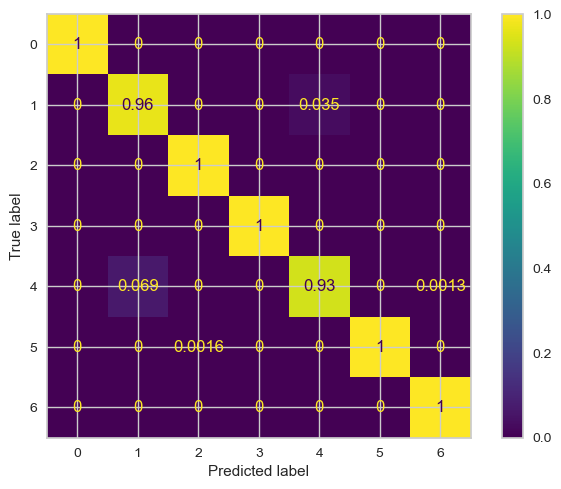

In [25]:
X_synthetic = df_prepared.drop('cat__PlayType')
y_synthetic = df_prepared.select('cat__PlayType').to_numpy().ravel()
lr.fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(lr, X_synthetic, y_synthetic, normalize='true')